**Описание проекта**

Руководство онлайн-площадки по реализации подержанных авто "Верная лошадка" хочет разработать приложение для привлечения новых клиентов. В приложении можно будет приблизительно оценить рыночную стоимость своего автомобиля. В нашем распоряжении данные объявлений о продаже авто за прошлые годы: технические характеристики, комплектации и цены автомобилей. Нам необходимо создать модель для определения цены. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Признаки
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - NotRepaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
Целевой признак

 - Price — цена (евро)

**Содержание проекта**

- [1. Подготовка данных](#1.-Подготовка-данных)
 - [1.1 Знакомство с данными](#1.1-Знакомство-с-данными)
 - [1.2 Работа с пропусками и дубликатами](#1.2-Работа-с-пропусками-и-дубликатами)
 - [1.3 Отбор признаков](#1.3-Отбор-признаков)
- [2. Обучение моделей](#2.-Обучение-моделей)
 - [2.1 Случайный лес](#2.1-Случайный-лес)
 - [2.2 Линейная регрессия](#2.2-Линейная-регрессия)
 - [2.3 LightGBM](#2.3-LightGBM)
 - [2.4 CatBoost](#2.4-CatBoost)
- [3. Анализ моделей](#3.-Анализ-моделей)

# 1. Подготовка данных

## 1.1 Знакомство с данными 

In [1]:
import pandas as pd
import numpy as np
import time
from lightgbm import LGBMRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,  GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

После импорта необходимых нам библиотек загрузим данные и ознакомимся с ними.

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DateCrawled,354369,271174,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,354369.0,NaN,NaN,NaN,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
VehicleType,316879,8,sedan,91457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RegistrationYear,354369.0,NaN,NaN,NaN,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Gearbox,334536,2,manual,268251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Power,354369.0,NaN,NaN,NaN,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Model,334664,250,golf,29232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kilometer,354369.0,NaN,NaN,NaN,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,NaN,NaN,NaN,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
FuelType,321474,7,petrol,216352,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Первое, что обращает на себя внимание - это большое количество пропусков, выделяются такие признаки, как "тип кузова", "тип топлива" и что-то про ремонт.

Также, на наш взгляд, необходимо переименовать названия столбцов - пробелы оформить в нижние подчеркивания и писать все со строчной буквы.

In [5]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
               'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'not_repaired',
               'date_created', 'number_of_pictures', 'postal_code', 'last_seen']
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


## 1.2 Работа с пропусками и дубликатами 

Сначала обратимся к одному нюансу. Признак "была машина в ремонте или нет" допускает разное толкование. Если мы будем опираться на английское название столбца 'not repaired', то оно будет скорее трактоваться как "неотремотирована" - то есть ответ 'yes' говорит, что она находится в битом состоянии, а ответ 'no' - отремонтирована, то есть на ходу.

Если же мы обратимся к русской трактовке признака, которая дана в описании данных, то на вопрос "была машина в ремонте или нет" положительный ответ "да" будет означать, что она отремонтирована. Для прояснения ситуации отдельно исследуем этот признак.

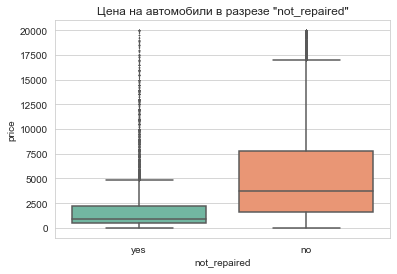

In [6]:
sns.set_style('whitegrid')
sns.boxplot(data = data, x='not_repaired', y='price', palette='Set2', fliersize=0.5)
plt.title('Цена на автомобили в разрезе "not_repaired"');

In [7]:
data['not_repaired'].value_counts()

no     247161
yes     36054
Name: not_repaired, dtype: int64

Итак, мы видим, что в объявлениях, где в 'not_repaired' указан ответ 'no' - медианная цена гораздо выше, чем там, где 'yes'. Значит, мы для себя можем определить, что этот признак выражает на ходу машина или нет. 

'not_repaired' - 'не отремонтирована': 'no' - нет, не "не отремонтирована" - значит, на ходу; 'yes' - да, "не отремонтирована", значит, не на ходу.

Также анализ объявления реальных площадок показал, что есть такой параметр как "битая" - и там объявления машин после аварий. Значит, признак 'not_repaired' для нас выступает в роли такого флажка - 'no' - все в порядке, можно ездить, 'yes' - битая, ездить вряд ли получится.

Если бы это был реальная задача, ты мы бы сделали запрос в источнику выгрузки базы данных.

Проверим данные на дубликаты.

In [8]:
duplicates = data[data.duplicated()] 
duplicates

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Всего 4, но есть, удалим их.

In [9]:
data = data.drop_duplicates().reset_index(drop=True)

Далее посмотрим на то, какой вообще временной промежуток охватывают скачанные из базы анкеты.

In [10]:
data.sort_values(by='date_crawled', ascending=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
329493,2016-03-05 14:06:22,150,small,1997,manual,75,polo,150000,4,petrol,volkswagen,no,2016-03-05 00:00:00,0,35789,2016-03-27 17:16:15
220582,2016-03-05 14:06:23,3999,wagon,2003,manual,220,a6,150000,7,petrol,audi,no,2016-03-05 00:00:00,0,57080,2016-03-06 18:29:35
176822,2016-03-05 14:06:24,6200,convertible,2006,manual,135,megane,90000,9,petrol,renault,no,2016-03-05 00:00:00,0,35764,2016-03-24 09:16:44
324760,2016-03-05 14:06:24,799,small,1997,manual,60,polo,150000,11,petrol,volkswagen,no,2016-03-05 00:00:00,0,35708,2016-03-09 15:19:01
99885,2016-03-05 14:06:24,10900,suv,2003,auto,245,NaN,150000,11,petrol,sonstige_autos,no,2016-03-05 00:00:00,0,56072,2016-04-06 22:15:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204217,2016-04-07 14:36:53,6990,coupe,1979,auto,143,3er,150000,6,petrol,bmw,no,2016-04-07 00:00:00,0,71336,2016-04-07 14:36:53
53739,2016-04-07 14:36:54,400,small,1996,manual,60,ibiza,150000,0,NaN,seat,NaN,2016-04-07 00:00:00,0,66299,2016-04-07 14:36:54
301027,2016-04-07 14:36:55,15200,wagon,2008,manual,190,a6,150000,9,gasoline,audi,no,2016-04-07 00:00:00,0,81476,2016-04-07 14:36:55
339645,2016-04-07 14:36:56,8650,suv,1992,manual,121,wrangler,125000,5,petrol,jeep,no,2016-04-07 00:00:00,0,20357,2016-04-07 14:36:56


Получается, мы имеем дело с временным периодом около месяца - примерно март 2016 года.

In [11]:
data.sort_values(by='date_created', ascending=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
61207,2016-03-16 11:48:06,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10 00:00:00,0,79669,2016-04-07 04:46:24
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20 00:00:00,0,24558,2016-04-07 03:45:01
342271,2016-03-05 21:44:26,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18 00:00:00,0,76275,2016-04-05 17:46:09
86601,2016-04-02 19:47:40,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07 00:00:00,0,76228,2016-04-07 09:15:23
175102,2016-03-08 17:57:45,5200,convertible,2006,manual,109,2_reihe,80000,11,petrol,peugeot,no,2015-08-10 00:00:00,0,26382,2016-04-05 20:46:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184410,2016-04-07 00:36:23,550,small,1997,manual,60,ka,150000,0,petrol,ford,no,2016-04-07 00:00:00,0,59077,2016-04-07 00:36:23
262337,2016-04-07 03:36:20,2190,wagon,1998,manual,110,a4,150000,6,gasoline,audi,no,2016-04-07 00:00:00,0,66606,2016-04-07 03:36:20
214461,2016-04-07 03:25:37,1890,wagon,2000,manual,150,a4,5000,8,gasoline,audi,no,2016-04-07 00:00:00,0,63065,2016-04-07 08:06:18
241967,2016-04-07 13:36:25,15490,convertible,2010,manual,150,c_reihe,125000,6,gasoline,volvo,no,2016-04-07 00:00:00,0,52076,2016-04-07 13:36:25


При этом анкеты создавались в течение двух лет - с 2014 года.

In [12]:
data.sort_values(by='last_seen', ascending=True)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
296782,2016-03-05 14:07:08,550,small,2001,manual,75,corsa,150000,5,NaN,opel,yes,2016-03-05 00:00:00,0,65232,2016-03-05 14:15:08
262338,2016-03-05 14:08:46,9000,sedan,2011,manual,109,c_reihe,90000,3,gasoline,volvo,no,2016-03-04 00:00:00,0,61348,2016-03-05 14:15:16
130462,2016-03-05 14:13:50,1200,wagon,2000,manual,115,passat,150000,5,NaN,volkswagen,no,2016-03-03 00:00:00,0,35606,2016-03-05 14:15:39
285692,2016-03-05 14:18:30,2850,sedan,1990,NaN,0,other,150000,2,petrol,mercedes_benz,no,2016-03-03 00:00:00,0,35781,2016-03-05 14:18:30
169065,2016-03-05 14:06:47,599,small,1997,manual,50,polo,100000,4,petrol,volkswagen,no,2016-03-05 00:00:00,0,60489,2016-03-05 14:25:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59506,2016-03-21 16:29:26,6250,wagon,2005,auto,204,a4,150000,9,gasoline,audi,no,2016-03-21 00:00:00,0,65620,2016-04-07 14:58:50
290309,2016-03-19 23:42:29,1459,wagon,1998,manual,90,golf,150000,8,gasoline,volkswagen,no,2016-03-19 00:00:00,0,74078,2016-04-07 14:58:50
245596,2016-03-19 21:53:27,9000,suv,2007,auto,218,other,150000,2,gasoline,jeep,no,2016-03-19 00:00:00,0,22391,2016-04-07 14:58:50
68870,2016-03-21 16:06:19,11200,convertible,2002,auto,231,3er,125000,1,petrol,bmw,no,2016-03-21 00:00:00,0,55425,2016-04-07 14:58:50


Пользователи также появлялись на сайте в течение последнего месяца, значит, можно говорить о том, что ценовые данные даже для старых объявлений - актуальны.

Далее построим боксплоты, чтобы взглянуть на то, адекватные ли в нашей базе данные.

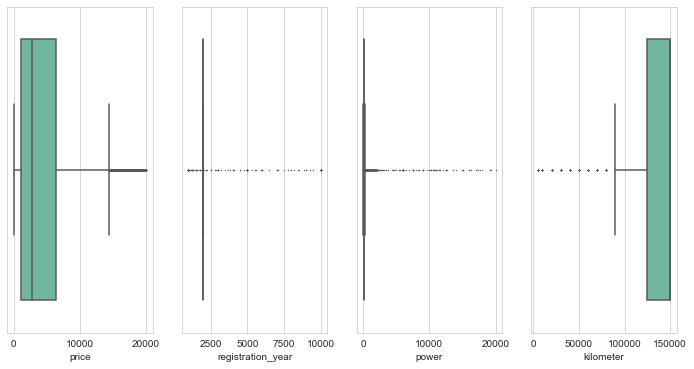

In [13]:
features_to_plot = {'price':0, 'registration_year':1, 'power':2,'kilometer':3}
fig, axes = plt.subplots(1,4, figsize = (12,6))
for feature, pos in features_to_plot.items():
    sns.boxplot(x=data[feature], orient='h', palette='Set2', fliersize=0.5, ax=axes[pos]);

Целевой признак price, 2 вывода:
 1. На нашем сервисе, видимо, в основном представлены бюджетные автомобили, если медиана составляет около 2700 тыс. евро.
 2. Есть автомобили с ценой 0 - нам предстоит понять, что это - неявные пропуски или продавцы отдают в дар.
 
'regisrtation_year' - налицо аномалии, много значений выше 2500 тысяч, нужно будет посмотреть на них и, видимо, избавиться.

'power' - также неадекватно высокая мощность, возможно, предстоит избавиться.

'kilometer' - столбец с пробегом вопросом не вызывает, кроме того, что медиана - 150 тыс. км и максимальное значение такое же. Возможно, при выгрузке данных стоял какой-то фильтр что-то вроде пробег не более 150 000 км, поэтому будем работать с тем, что есть.

Итак, узнаем, в скольких объявлениях указана цена 0.

In [14]:
data['price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

Посмотрим, что это за автомобили.

In [15]:
priceless = data[data['price'] == 0]
priceless

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354201,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354234,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354244,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354273,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


In [16]:
priceless.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,10772,10682,2016-03-20 13:42:08,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,10772.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vehicle_type,7032,8,sedan,2052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,10772.0,NaN,NaN,NaN,2008.848403,267.729824,1000.0,1996.0,2000.0,2005.0,9999.0
gearbox,8294,2,manual,6878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,10772.0,NaN,NaN,NaN,81.200056,235.273205,0.0,0.0,75.0,120.0,15016.0
model,8588,222,golf,986,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,10772.0,NaN,NaN,NaN,124177.961381,48423.379468,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,10772.0,NaN,NaN,NaN,3.697271,4.046864,0.0,0.0,2.0,7.0,12.0
fuel_type,7336,7,petrol,5587,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Здесь для нас ключевое значение имеет столбец 'not_repaired' - таблица говорит, что 3479 были отремонтированы, а остальные (чуть менее 3000) - не отремонтированы. Значит, тут встречаются разные автомобили, и цена 0 - неявный пропуск. С учетом того, что это целевой признак, проявлять фантазию и пытаться заполнить модами или медианами выглядит опасным, поэтому придется избавиться от этих данных.

То есть, если бы мы однозначно увидели, что все автомобили с нулевой ценой в столбце 'not_repaired' имеют 'yes' - то есть они были бы не находу - тогда мы теоретически могли бы сказать, что в этом срезе у нас автохлам.

Отбросим объявления с нулевой ценой.

In [17]:
data = data[data['price'] > 0]
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,343593,265135,2016-03-24 14:49:47,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,343593.0,NaN,NaN,NaN,4555.147363,4515.0762,1.0,1200.0,2890.0,6500.0,20000.0
vehicle_type,309843,8,sedan,89405,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,343593.0,NaN,NaN,NaN,2004.08983,78.41368,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,326238,2,manual,261371,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,343593.0,NaN,NaN,NaN,110.999665,188.178919,0.0,69.0,105.0,143.0,20000.0
model,326072,250,golf,28246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,343593.0,NaN,NaN,NaN,128337.81538,37520.773792,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,343593.0,NaN,NaN,NaN,5.777897,3.698197,0.0,3.0,6.0,9.0,12.0
fuel_type,314134,7,petrol,210762,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Далее попробуем исследовать столбец c пропусками 'not_repaired'. Сделаем срез автомобилей, которые "на ходу".

In [18]:
data[data['not_repaired'] == 'no'].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,243679,202556,2016-04-01 19:25:23,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,243679.0,NaN,NaN,NaN,5372.479118,4714.660667,1.0,1690.0,3790.0,7800.0,20000.0
vehicle_type,231350,8,sedan,68006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,243679.0,NaN,NaN,NaN,2003.739543,25.047842,1000.0,2000.0,2004.0,2008.0,9999.0
gearbox,238328,2,manual,188655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,243679.0,NaN,NaN,NaN,118.640818,162.131225,0.0,75.0,110.0,150.0,20000.0
model,235821,249,golf,20052,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,243679.0,NaN,NaN,NaN,126342.319199,37749.982564,5000.0,100000.0,150000.0,150000.0,150000.0
registration_month,243679.0,NaN,NaN,NaN,6.153981,3.50435,0.0,3.0,6.0,9.0,12.0
fuel_type,231952,7,petrol,152440,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что средняя цена около 5400 евро, медиана - 3790.

Посмотрим, как обстоят дела у автомобилей "не на ходу".

In [19]:
data[data['not_repaired'] == 'yes'].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,34048,33229,2016-04-01 19:48:47,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,34048.0,NaN,NaN,NaN,2028.788005,2706.006825,1.0,500.0,999.0,2400.0,20000.0
vehicle_type,30601,8,small,8490,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,34048.0,NaN,NaN,NaN,2001.739104,45.884756,1000.0,1998.0,2001.0,2005.0,9000.0
gearbox,32702,2,manual,26938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,34048.0,NaN,NaN,NaN,103.705621,216.756408,0.0,60.0,101.0,136.0,19208.0
model,31958,241,other,2887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,34048.0,NaN,NaN,NaN,136311.090226,31742.422258,5000.0,150000.0,150000.0,150000.0,150000.0
registration_month,34048.0,NaN,NaN,NaN,5.388187,3.782754,0.0,2.0,5.0,9.0,12.0
fuel_type,30531,7,petrol,21800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Тут средняя цена около 2030 евро, а медиана - 999 евро.

Отберем объявления с пропусками в 'not_repaired'.

In [20]:
nan_repaired = data[data['not_repaired'].isna()]

In [21]:
nan_repaired.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,65866,62312,2016-03-08 21:47:46,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,65866.0,NaN,NaN,NaN,2837.279249,3406.194219,1.0,690.0,1500.0,3500.0,20000.0
vehicle_type,47892,8,small,14245,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,65866.0,NaN,NaN,NaN,2006.600917,169.281728,1000.0,1998.0,2001.0,2007.0,9999.0
gearbox,55208,2,manual,45778,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,65866.0,NaN,NaN,NaN,86.50082,249.690554,0.0,0.0,75.0,122.0,19211.0
model,58293,244,golf,5804,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,65866.0,NaN,NaN,NaN,131598.776303,38635.196987,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,65866.0,NaN,NaN,NaN,4.587982,4.06175,0.0,0.0,4.0,8.0,12.0
fuel_type,51651,7,petrol,36522,NaN,NaN,NaN,NaN,NaN,NaN,NaN


У таких объявлений средняя цена составляет около 2800 евро, а медиана - 1500. То есть, такие цены больше тяготеют к выборке автомобилей не на ходу, то есть - с ответами 'yes'. Из-за близости средней цены рискнем сделаем выбор в пользу заполнения пропусков параметром 'yes'.

Жалко удалять такой большой массив данных.

In [22]:
data['not_repaired'] = data['not_repaired'].fillna('yes')
data['not_repaired'].value_counts()

no     243679
yes     99914
Name: not_repaired, dtype: int64

Далее проанализируем признак 'год регистрации'. В наших данных не может быть автомобилей с годом регистрации больше 2016.

In [23]:
cars_from_future = data[data['registration_year'] > 2016]
cars_from_future.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date_crawled,13779,13627,2016-03-23 11:56:04,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,13779.0,NaN,NaN,NaN,3324.007185,3470.907197,1.0,1050.0,2000.0,4250.0,20000.0
vehicle_type,19,8,wagon,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,13779.0,NaN,NaN,NaN,2043.060091,384.355937,2017.0,2017.0,2017.0,2018.0,9999.0
gearbox,12072,2,manual,10207,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,13779.0,NaN,NaN,NaN,89.073735,252.70624,0.0,0.0,80.0,117.0,16011.0
model,11920,227,golf,1505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,13779.0,NaN,NaN,NaN,131936.642717,36573.752919,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,13779.0,NaN,NaN,NaN,4.807969,3.994933,0.0,1.0,4.0,8.0,12.0
fuel_type,8538,7,petrol,6039,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
cars_from_future

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,yes,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354108,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,yes,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354136,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,yes,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27
354199,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04
354249,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,yes,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13


Анализ этого среза и визуальный осмотр объявлений говорит нам о том, что здесь вроде как нет определенной системы в пропусках - представлены машины различных брендов и моделей, типов топлива. При этом почти у всех у них есть пропуски в типе кузове.

С учетом этого, также избавимся от этих данных.

In [25]:
data = data[data['registration_year'] < 2017]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 329814 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        329814 non-null  object
 1   price               329814 non-null  int64 
 2   vehicle_type        309824 non-null  object
 3   registration_year   329814 non-null  int64 
 4   gearbox             314166 non-null  object
 5   power               329814 non-null  int64 
 6   model               314152 non-null  object
 7   kilometer           329814 non-null  int64 
 8   registration_month  329814 non-null  int64 
 9   fuel_type           305596 non-null  object
 10  brand               329814 non-null  object
 11  not_repaired        329814 non-null  object
 12  date_created        329814 non-null  object
 13  number_of_pictures  329814 non-null  int64 
 14  postal_code         329814 non-null  int64 
 15  last_seen           329814 non-null  object
dtypes:

Также мы видели, что встречаются средневековые года выпуска. Отберем автомобили из прошлого. Мы помним, что у нас в выборке относительно дешевые автомобили, поэтому выдвинем гипотезу о том, что если бы у нас в объявлениях встречались реально старые автомобили, то они являлись бы раритетными, и их цена была бы выше 20000 евро. Поэтому, на наш взгляд, можно ограничить год выпуска автомобилей снизу 1980 годом. Старые автомобили из более нового промежутка еще не успели стать ценными.

In [26]:
data = data[data['registration_year'] > 1979]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326648 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        326648 non-null  object
 1   price               326648 non-null  int64 
 2   vehicle_type        306967 non-null  object
 3   registration_year   326648 non-null  int64 
 4   gearbox             311594 non-null  object
 5   power               326648 non-null  int64 
 6   model               311738 non-null  object
 7   kilometer           326648 non-null  int64 
 8   registration_month  326648 non-null  int64 
 9   fuel_type           303023 non-null  object
 10  brand               326648 non-null  object
 11  not_repaired        326648 non-null  object
 12  date_created        326648 non-null  object
 13  number_of_pictures  326648 non-null  int64 
 14  postal_code         326648 non-null  int64 
 15  last_seen           326648 non-null  object
dtypes:

Далее отберем автомобили с аномальными значениями мощности, выраженной в лошадиных силах.

Отбросим объявления с мощностью автомбилей выше 500 - в прицнипе автомобили с такими двигателями редки.

In [27]:
data = data[data['power'] < 500]

Посмотрим, сколько нулевых значений.

In [28]:
data[data['power'] < 1]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354332,2016-03-05 18:57:45,3299,NaN,2005,auto,0,outlander,150000,4,petrol,mitsubishi,yes,2016-03-05 00:00:00,0,17034,2016-03-06 04:17:37
354334,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,yes,2016-03-31 00:00:00,0,41470,2016-04-06 14:18:04
354342,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,yes,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354359,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


Около 32000 объявлений не содержат информации о мощности двигателя.

Попробуем заполнить эту информацию. Сначала заменим нули на nan.

In [29]:
data['power'] = data['power'].replace(0, np.nan)

Затем заполним пропуски после группировки данных по марке, модели и году регистрации - возьмем медианное значение.

In [30]:
data['power'] = (
   data['power'].
    fillna(data.groupby(['brand', 'model','registration_year'])['power'].transform('median'))
)

In [31]:
data = data.dropna(subset=['power'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321835 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        321835 non-null  object 
 1   price               321835 non-null  int64  
 2   vehicle_type        304355 non-null  object 
 3   registration_year   321835 non-null  int64  
 4   gearbox             308807 non-null  object 
 5   power               321835 non-null  float64
 6   model               311093 non-null  object 
 7   kilometer           321835 non-null  int64  
 8   registration_month  321835 non-null  int64  
 9   fuel_type           300524 non-null  object 
 10  brand               321835 non-null  object 
 11  not_repaired        321835 non-null  object 
 12  date_created        321835 non-null  object 
 13  number_of_pictures  321835 non-null  int64  
 14  postal_code         321835 non-null  int64  
 15  last_seen           321835 non-nul

Далее попробуем заполнить пропуски в признаке "модель". Для этого сгруппируем данные по бренду и мощности и заполним пропуски модой.

In [32]:
data['model'] = data.groupby(['brand', 'power'])['model'].transform(lambda x: 
                                        x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

Далее также поступим для типа кузова, только сгруппируем по бренду и модели.

In [33]:
data['vehicle_type'] = data.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: 
                                        x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

Схожим образом поступим для коробки передач и типа топлива.

In [34]:
data['gearbox'] = data.groupby(['brand', 'model'])['gearbox'].transform(lambda x: 
                                        x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

In [35]:
data['fuel_type'] = data.groupby(['brand', 'model', 'power'])['fuel_type'].transform(lambda x: 
                                        x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321835 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        321835 non-null  object 
 1   price               321835 non-null  int64  
 2   vehicle_type        321835 non-null  object 
 3   registration_year   321835 non-null  int64  
 4   gearbox             321835 non-null  object 
 5   power               321835 non-null  float64
 6   model               321835 non-null  object 
 7   kilometer           321835 non-null  int64  
 8   registration_month  321835 non-null  int64  
 9   fuel_type           321835 non-null  object 
 10  brand               321835 non-null  object 
 11  not_repaired        321835 non-null  object 
 12  date_created        321835 non-null  object 
 13  number_of_pictures  321835 non-null  int64  
 14  postal_code         321835 non-null  int64  
 15  last_seen           321835 non-nul

Заменим пустые моды на nan.

In [36]:
data = data.replace('Empty', np.nan)

In [37]:
data['number_of_pictures'].value_counts()

0    321835
Name: number_of_pictures, dtype: int64

Признак "количество фото" имеет нулевые значение для всех объявлений - вероятно, какая-то ошибка при выгрузке данных.

Удалим оставшиеся пропуски.

In [38]:
data = data.dropna()

Проверим на дубликаты.

In [39]:
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319851 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        319851 non-null  object 
 1   price               319851 non-null  int64  
 2   vehicle_type        319851 non-null  object 
 3   registration_year   319851 non-null  int64  
 4   gearbox             319851 non-null  object 
 5   power               319851 non-null  float64
 6   model               319851 non-null  object 
 7   kilometer           319851 non-null  int64  
 8   registration_month  319851 non-null  int64  
 9   fuel_type           319851 non-null  object 
 10  brand               319851 non-null  object 
 11  not_repaired        319851 non-null  object 
 12  date_created        319851 non-null  object 
 13  number_of_pictures  319851 non-null  int64  
 14  postal_code         319851 non-null  int64  
 15  last_seen           319851 non-nul

Итак, после очистки данных осталось около 90% от исходного датасета. Потери есть, но большое количество пропущенных данных удалось восстановить более или менее логично.

## 1.3 Отбор признаков 

На первый взгляд, у нас есть признаки, не имеющие отношения к ценообразованию.

Обоснуем:
 - date_crawled - все объявления за месяц, поэтому фактор времени публикации не должен оказывать никакого влияния;
 - registration_month - признак не должен оказывать сильного значения, поскольку по общепринятым понятиям на цену машины влияет год выпуска или регистрации, роль месяца должна быть незначительна;
 - date_created - не слишком важная для нас информация, с учетом того, что мы знаем, что пользователи были активны, а значит - цены актуальны;
 - number_of_pictures - нулевые значения для всех, не нужен;
 - postal_code  - вероятно, лишняя информация, поскольку большее значение почтового кода не может означать более высокую цену. Кроме этого, специальные значения почтового кода также не должны влиять на стоимость автомобиля. Даже находясь в разных городах, автомобили должны обладать примерно одним ценовым уровнем;
 - last_seen - тоже ненужная для нас информация, мы знаем, что продавцы были активны в течение рассматриваемого месяца.

In [41]:
features = data[['price','registration_year', 'gearbox', 'power', 'model', 
                 'kilometer', 'fuel_type', 'brand', 'not_repaired']].reset_index(drop=True)
target = features['price']
features = features.drop('price', axis=1)

Создадим списки с количественными и категориальными переменными.

In [42]:
numeric= ['registration_year', 'power', 'kilometer']
categorical = ['gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

# 2. Обучение моделей

## 2.1 Случайный лес 

В задаче предлагается построить не только модели градиентного бустинга, но и более простые.

Попробуем составить модель регрессии на основе случайного леса. Это может быть интересно сделать, так как и случайный лес, и градиентный бустинг являются ансамблевыми алгоритмами, в основе которых лежит (очень грубо говоря) дерево решений.

Поскольку в наших данных присутствуют категориальные переменные, то для случайного леса их нужно закодировать. Воспользуемся порядковым кодированием, с которым познакомились в ходе теоретического курса.

In [43]:
features_rf = features.copy()

In [44]:
encoder = OrdinalEncoder()
features_rf[categorical] = pd.DataFrame(encoder.fit_transform(features_rf[categorical]),
                                   columns=features_rf[categorical].columns)

In [45]:
features_rf

,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,1993,1.0,75.0,116.0,150000,6.0,37.0,1.0
1,2011,1.0,190.0,29.0,125000,2.0,1.0,1.0
2,2004,0.0,163.0,117.0,125000,2.0,14.0,1.0
3,2001,1.0,75.0,116.0,150000,6.0,37.0,0.0
4,2008,1.0,69.0,101.0,90000,2.0,31.0,0.0
...,...,...,...,...,...,...,...,...
319846,2004,1.0,225.0,140.0,150000,6.0,30.0,1.0
319847,2000,1.0,116.0,247.0,150000,6.0,24.0,0.0
319848,2000,0.0,101.0,106.0,125000,6.0,32.0,0.0
319849,1996,1.0,102.0,222.0,150000,2.0,37.0,0.0


Итак, мы закодировали порядковые переменные, количественные оставили как есть. Для алгоритмов случайного леса их можно не масштабировать.

Разобьем данные на выборки, зарезервируем 25% под тестовую выборку.

In [46]:
features_train_rf, features_valid_rf, target_train_rf, target_valid_rf = train_test_split(
    features_rf, target, test_size=0.25, random_state=2)

Посмотрим как справится лес без настройки гиперпараметров.

In [47]:
%%time
rf_model_1 = RandomForestRegressor(random_state=2)
rf_model_1.fit(features_train_rf, target_train_rf)

CPU times: user 47.9 s, sys: 794 ms, total: 48.7 s
Wall time: 49.6 s


RandomForestRegressor(random_state=2)

In [48]:
rf_pred = rf_model_1.predict(features_valid_rf)
rf_mse = mean_squared_error(target_valid_rf, rf_pred) ** 0.5
rf_mse

1637.303684541521

Корень из среднеквадратической ошибки составил около 1675 евро, что выглядит довольно большим, поскольку составляет примерно треть от средней цены по всему датасету.

Попробуем немного подкрутить гиперпараметры.

In [49]:
rf_model_2 = RandomForestRegressor(random_state=2)

In [50]:
forest_params = {'n_estimators':[20, 50],
                'max_depth': range(21,23),
                'max_features': range(2,4),
                'min_samples_leaf': range(1,3)
}

best_forest = GridSearchCV(rf_model_2, forest_params, scoring='neg_mean_squared_error', 
                           cv=3, n_jobs=-1, verbose=True)

best_forest.fit(features_train_rf, target_train_rf)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.5min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=2), n_jobs=-1,
             param_grid={'max_depth': range(21, 23),
                         'max_features': range(2, 4),
                         'min_samples_leaf': range(1, 3),
                         'n_estimators': [20, 50]},
             scoring='neg_mean_squared_error', verbose=True)

In [51]:
(-best_forest.best_score_)**0.5

1631.3449535729633

На кросс-валидации RMSE еще немного уменьшилась.

In [52]:
best_forest.best_params_

{'max_depth': 22, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 50}

Таковы лучшие параметры. Обучим модель, применяя их.

Зафиксируем время обучения.

In [53]:
%%time
rf_best_model = RandomForestRegressor(random_state=2,max_depth= 22, max_features = 3, 
                                      n_estimators=50, min_samples_leaf=2) 
start = time.time()
rf_best_model.fit(features_train_rf, target_train_rf)

finish = time.time()
rf_time_fit = finish - start

CPU times: user 9.97 s, sys: 145 ms, total: 10.1 s
Wall time: 10.2 s


Сделаем предсказания.

In [54]:
%%time
start = time.time()

rf_pred = rf_best_model.predict(features_valid_rf)

finish = time.time()

rf_time_predict = finish - start

rf_rmse = mean_squared_error(target_valid_rf, rf_pred)**0.5
print(f'RMSE_Случайный_Лес={rf_rmse:.0f}')

RMSE_Случайный_Лес=1596
CPU times: user 1.04 s, sys: 7.81 ms, total: 1.05 s
Wall time: 1.05 s


Мы видим, что RMSE еще улучшилась - до 1600 евро. Взглянем ради интереса на значимость признаков.

In [55]:
rf_importance = pd.DataFrame({'feature': features_rf.columns,
                    'coef' : rf_best_model.feature_importances_}).sort_values('coef', ascending=False)
rf_importance

,feature,coef
0,registration_year,0.451622
2,power,0.269642
4,kilometer,0.106272
6,brand,0.047884
3,model,0.044547
7,not_repaired,0.029383
5,fuel_type,0.028966
1,gearbox,0.021684


Итак, первая тройка - это год регистрации, мощность и километраж. А вот, требуется машине ремонт или нет - не важный признак.

## 2.2 Линейная регрессия 

Далее попробуем построить модель линейной регрессии.

Разделим данные на обучающую и валидационную выборку.

In [56]:
features_train_lr, features_valid_lr, target_train_lr, target_valid_lr = train_test_split(
    features, target, test_size=0.25, random_state=2)

Сперва масштабируем количественные переменные.

In [57]:
scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_valid_lr[numeric] = scaler.transform(features_valid_lr[numeric])

Мы знаем, что линейная регрессия не может обрабатывать категориальные переменные, значит, их нужно закодировать. Воспользуемся техникой OHE, обучим объект на обучающей выборке, и затем трансформируем обучающую и тестовую выборки.

In [58]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(features_train_lr[categorical])

OneHotEncoder(handle_unknown='ignore')

In [59]:
features_train_lr = enc.transform(features_train_lr[categorical])

In [60]:
features_valid_lr = enc.transform(features_valid_lr[categorical])

Обучим модель линейной регрессии.

In [61]:
%%time
linreg = LinearRegression()
start = time.time()
linreg.fit(features_train_lr, target_train_lr)
finish = time.time()

lr_time_fit = finish - start

CPU times: user 11.3 s, sys: 656 ms, total: 11.9 s
Wall time: 3.19 s


Обучалась достаточно долго. Сделаем предсказания.

In [62]:
%%time
start = time.time()
test_pred = linreg.predict(features_valid_lr)
finish = time.time()

lr_time_predict = finish - start

lr_rmse = mean_squared_error(target_valid_lr, test_pred)**0.5
print(f'RMSE_Линейная регрессия={lr_rmse:.0f}')


RMSE_Линейная регрессия=3532
CPU times: user 6.68 ms, sys: 1.99 ms, total: 8.67 ms
Wall time: 3.05 ms


RMSE значительно хуже, чем у случайного леса - более 3500 евро.

## 2.3 LightGBM

Далее построим модель градиентного бустинга с помощью библиотеки LightGBM.

In [63]:
features_gbm = features.copy()

LightGBM обрабатывает категориальные переменные напрямую, однако для этого необходимо присвоить им тип 'category'.

In [64]:
features_gbm[categorical] = features[categorical].astype('category')

Снова разобьем данные на обучающую и тестовую выборки.

In [65]:
features_train_gbm, features_valid_gbm, target_train_gbm, target_valid_gbm = train_test_split(
            features_gbm, target, test_size=0.25, random_state=2)

In [66]:
scaler = StandardScaler()
scaler.fit(features_train_gbm[numeric])
features_train_gbm[numeric] = scaler.transform(features_train_gbm[numeric])
features_valid_gbm[numeric] = scaler.transform(features_valid_gbm[numeric])

Обучим модель без настройки гиперпараметров, однако выберем количество листьев в 27, чтобы избежать ошибки.

In [67]:
%%time
lgbm_reg = LGBMRegressor(random_state=2, num_leaves=27)

start = time.time()

lgbm_reg.fit(features_train_gbm, target_train_gbm,
             eval_metric='rmse', categorical_feature=categorical)

finish = time.time()

lgbm_time_fit = finish - start

CPU times: user 6.37 s, sys: 550 ms, total: 6.92 s
Wall time: 1.59 s


In [68]:
%%time
start = time.time()
lgbm_pred = lgbm_reg.predict(features_valid_gbm)
finish = time.time()

lgbm_time_predict = finish - start

lgbm_rmse = mean_squared_error(target_valid_gbm, lgbm_pred) ** 0.5
print(f'RMSE_Light_GBM={lgbm_rmse:.0f}')

RMSE_Light_GBM=1648
CPU times: user 1.05 s, sys: 52.2 ms, total: 1.1 s
Wall time: 213 ms


RMSE составила 1640 евро, что существенно лучше, чем у линейной регрессии, но хуже, чем у случайного леса.

Далее попробуем изменить некоторые гиперпараметры, чтобы добиться немного лучших результатов.

Увеличим число деревьев до 400, количество листьев ограничим пятью, а скорость обучения повысим до 0.27.

In [69]:
%%time
lgbm_reg = LGBMRegressor(objective='rmse',
                         random_state=2, num_leaves=5, learning_rate=0.27, n_estimators=400)

start = time.time()

lgbm_reg.fit(features_train_gbm, target_train_gbm, categorical_feature=categorical, verbose=10)

finish = time.time()

lgbm_time_fit = finish - start

CPU times: user 7.65 s, sys: 633 ms, total: 8.29 s
Wall time: 1.67 s


In [70]:
%%time
start = time.time()
lgbm_pred = lgbm_reg.predict(features_valid_gbm)
finish = time.time()

lgbm_time_predict = finish - start

lgbm_rmse = mean_squared_error(target_valid_gbm, lgbm_pred) ** 0.5
print(f'RMSE_Light_GBM={lgbm_rmse:.0f}')

RMSE_Light_GBM=1655
CPU times: user 1.7 s, sys: 54.9 ms, total: 1.75 s
Wall time: 327 ms


Итак, мы видим, что RMSE не сильно поменялась и не превысила метрику случайного леса.

## 2.4 CatBoost 

Далее попробуем построить модели в библиотеке CatBoost - она таке может напрямую работать с категориальными переменными, поэтому воспользуемся выборками, сделанными для LightGBM.

Данная модель обучается очень долго, поэтому сразу попробуем ее запустить с настройкой гиперпараметров. Выберем число итераций и по опыту light_gbm поставить скорость обучения в 0.2

In [71]:
cb_reg = CatBoostRegressor(loss_function = 'RMSE', cat_features=categorical, iterations=600,
                          learning_rate=0.2, verbose=100, random_state=2, l2_leaf_reg=0.001)

In [72]:
%%time

start = time.time()

cb_reg.fit(features_train_gbm, target_train_gbm)

finish = time.time()

cb_time_fit = finish - start

0:	learn: 3946.7543764	total: 120ms	remaining: 1m 12s
100:	learn: 1708.2794623	total: 6.34s	remaining: 31.3s
200:	learn: 1647.9710447	total: 12.8s	remaining: 25.5s
300:	learn: 1615.1272786	total: 19.3s	remaining: 19.2s
400:	learn: 1589.8045422	total: 27s	remaining: 13.4s
500:	learn: 1570.8869626	total: 33.1s	remaining: 6.53s
599:	learn: 1556.1356197	total: 39.2s	remaining: 0us
CPU times: user 2min 26s, sys: 23.9 s, total: 2min 50s
Wall time: 39.9 s


In [73]:
%%time
start = time.time()
cb_pred = cb_reg.predict(features_valid_gbm)
finish = time.time()

cb_time_predict = finish - start

cb_rmse = mean_squared_error(target_valid_gbm, cb_pred) ** 0.5
print(f'RMSE_Cat_Boost={cb_rmse:.0f}')

RMSE_Cat_Boost=1623
CPU times: user 503 ms, sys: 20.4 ms, total: 523 ms
Wall time: 148 ms


Модель обучалась больше 5 минут, но побить RMSE ни случайного леса, ни LightGBM не смогла.

# 3. Анализ моделей

Итак, на этом этапе сравним данные моделей, но сперва проверим модели на адекватность - сравним со средним.

In [74]:
dummy_predict = pd.Series(target_train_rf.mean(), index=target_valid_rf.index) ### ошибка 
dummy_rmse = mean_squared_error(target_valid_rf, dummy_predict)**0.5
dummy_rmse

4534.948738696544

Получается корень из среднеквадратической ошибки между целевым признаком и средним составляет около 4500 евро, что существенно выше, чем все наши модели.

In [75]:
rf_list = [rf_rmse, rf_time_fit, rf_time_predict]
lr_list = [lr_rmse, lr_time_fit, lr_time_predict]
lgbm_list = [lgbm_rmse, lgbm_time_fit, lgbm_time_predict]
cb_list = [cb_rmse, cb_time_fit, cb_time_predict]

In [76]:
overall = pd.DataFrame(data=[rf_list, lr_list, lgbm_list, cb_list],
                       columns=['RMSE', 'Время_обучения', 'Время_предсказания'],
                      index=['Случайный_лес', 'Линейная_регрессия', 'Light_GBM', 'CatBoost'])
overall.sort_values('RMSE')

,RMSE,Время_обучения,Время_предсказания
Случайный_лес,1595.876166,10.175838,1.053225
CatBoost,1622.910396,39.941934,0.146767
Light_GBM,1654.687041,1.672991,0.326380
Линейная_регрессия,3532.139819,3.188883,0.001877


Лучшей по качеству оказался случайный лес - но его RMSE была ниже метрики LightGBM только на 50 евро. А обучалась дольше. 

CatBoost обучался также достаточно долго, но по метрике уступил лесу, но не LightGBM. 

Вероятно, заказчику можно предоставить на выбор две модели - на основе случайного леса и CatBoost. Но CatBoost уступает лесу по скорости и качеству.